# MPC 4 for Continuous Reading and Piloting


In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from gekko import GEKKO

In [17]:
import pickle
with open('p_gek_full_6-8-23.pkl', 'rb') as file:   # na=4 nb=10 .. highly fit, with 0's shutdown 
    p = pickle.load(file)
#new p array: ARX coefficients

In [3]:
# Get initial Process data for 5 time steps.
df0=pd.read_excel('CC_185802:229370.xlsx',header=0,index_col=0)   #training set. last few weeks of data
df0.head()

df0.columns = ['F', 'FW', 'P', 'MS', 'BP_1', 'SW', 'SL', 'D', 'PS', 'CP', 'BP','D50']
#df0.columns = ['min','F', 'FW','MS','PS','SW','BP','P','SL', 'D', 'CP', 'D50']
#attention
df=df0.iloc[60:]  #after startup

MV=['F','FW','MS','SW','PS']
CV=['BP','P','SL','D','CP','D50']

In [ ]:
#df.iloc[0]

Acceptable Ranges
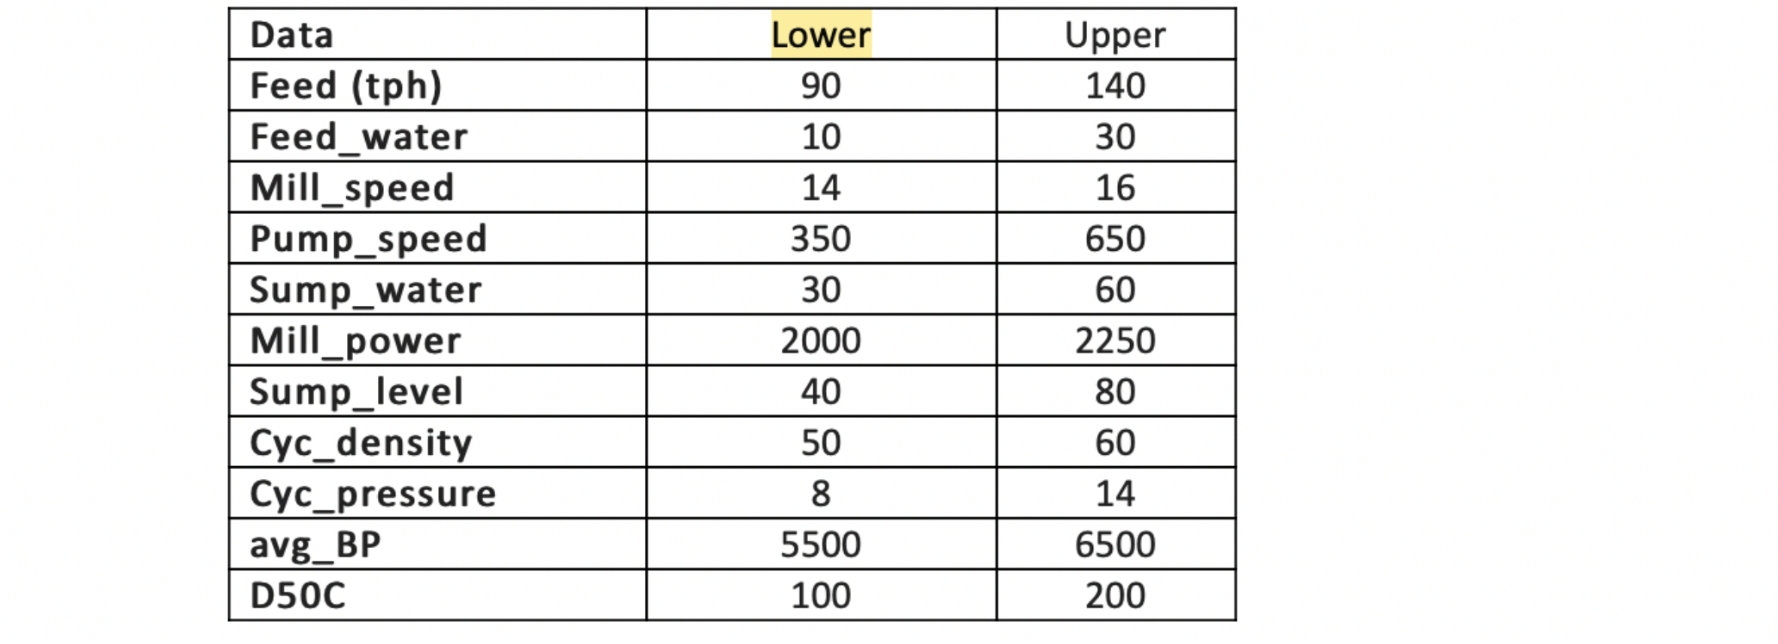

In [ ]:
###### Full Controller First Run #############

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
#import random
import json
#from IPython.display import clear_output
from gekko import GEKKO

######################
# Final time
tf = 20   # min   #remember we used 1 min trained data. #45 is best yet
######################
# number of data points (every 1 minute)
n = tf * 1 + 1

#write mv controller outputs. for testing/plotting controller results
dfw=np.zeros((5,n)) 
for i, tag in enumerate([dfw[0],dfw[1],dfw[2],dfw[3],dfw[4]]):  #Setting starting values to read.
    tag[0]=df[MV[i]].iloc[0]
    tag[1]=df[MV[i]].iloc[1]
    tag[2]=df[MV[i]].iloc[2]
    tag[3]=df[MV[i]].iloc[3]
    tag[4]=df[MV[i]].iloc[4]
    tag[5]=df[MV[i]].iloc[5]


#write cv calc/expect/sim outputs. (for testing controller)
dfx=np.zeros((6,n)) ##NUMbet!!

# MV initialize arrays:
#s is for sensor
Fs  = np.zeros(n)
FWs = np.zeros(n)
MSs = np.zeros(n)
SWs = np.zeros(n)
PSs = np.zeros(n)


for i, tag in enumerate([Fs,FWs,MSs,SWs,PSs]):  #Setting MV starting values. 
    tag[0]=df[MV[i]].iloc[0]                    #would read from process.
    tag[1]=df[MV[i]].iloc[1]    #tag[0]*1.0     #2nd time step added as well.
    tag[2]=df[MV[i]].iloc[2]
    tag[3]=df[MV[i]].iloc[3]
    tag[4]=df[MV[i]].iloc[4]
    tag[5]=df[MV[i]].iloc[5]
    
# CV values measurement arrays
BPm  = df['BP'].iloc[0] * np.ones(n)
Pm   = df['P'].iloc[0]  * np.ones(n)
SLm  = df['SL'].iloc[0] * np.ones(n)
Dm   = df['D'].iloc[0]  * np.ones(n)
CPm  = df['CP'].iloc[0] * np.ones(n)
D50m = df['D50'].iloc[0]* np.ones(n)

for i, tag in enumerate([BPm,Pm,SLm,Dm,CPm,D50m]):  #Setting MV starting values. 
    tag[0]=df[CV[i]].iloc[0]                    #would read from process.
    tag[1]=df[CV[i]].iloc[1]    #tag[0]*1.0     #2nd time step added as well.
    tag[2]=df[CV[i]].iloc[2]
    tag[3]=df[CV[i]].iloc[3]
    tag[4]=df[CV[i]].iloc[4]
    tag[5]=df[CV[i]].iloc[5]
    tag[6]=df[CV[i]].iloc[6]
    
# CV setpointsarrays
BPsp = BPm*1.0
Psp  = Pm*1.0
SLsp = SLm*1.0
Dsp  = Dm*1.0
CPsp = CPm*1.0
D50sp= D50m*1.0

# BPsp = BPm[0] * np.ones(n)
# Psp  = Pm[0]  * np.ones(n)
# SLsp = SLm[0] * np.ones(n)
# Dsp  = Dm[0]  * np.ones(n)
# CPsp = CPm[0] * np.ones(n)
# D50sp= D50m[0]* np.ones(n)

# set sp's for each CV var.  IDEAL
BPsp [6:] = 6250        #   15-20 min settling time
Psp  [6:] = 2200
SLsp [6:] = 60
Dsp  [6:] = 55
CPsp [6:] = 11
D50sp[6:] = 0.110

#Changes 
def change(name,i,sp):
    try:
        BPsp [i:] = 6250        #   15-20 min settling time
        Psp  [i:] = 2200
        SLsp [i:] = 60
        Dsp  [i:] = 55
        CPsp [i:] = 11
        D50sp[i:] = 0.110
        name [i:] = sp
    except:
        print('sp array exceeded, increase tf')

#change(SLsp ,20,30)
change(D50sp,30,0.130)
#change(D50sp,35,0.110)
#change(CPsp ,50,12)
# change(D50sp,60,0.11)
# change(Psp  ,80,6000)
# change(BPsp ,100,2000)
# change(CPsp ,100,11)
# change(Dsp  ,120,40)

# #Reset
# BPsp [150:] = 6250        #   15-20 min settling time
# Psp  [150:] = 2200
# SLsp [150:] = 60
# Dsp  [150:] = 55
# CPsp [150:] = 11
# D50sp[150:] = 0.110


#dbd={'BP':100,'P':100,'SL':20,'D':5,'CP':3,'D50':0.02} This is defined below. written here for reference only

#########################################################
# Initialize Models    
#########################################################

#Manipulated variables
MV = [ 'F', 'FW', 'MS', 'SW', 'PS']

#Controlled variables
CV = ['BP','P', 'SL', 'D', 'CP', 'D50']

#create control model:

m = GEKKO(remote=False)
y = m.Array(m.CV,6)
u = m.Array(m.MV,5)

y,u = m.arx(p,y,u)

#initial value match to df values. will need to read value from process on real startup
for i in range(len(y)):
    y[i].value=df[CV[i]].iloc[0]  

# rename CVs
BP = y[0]
P  = y[1]
SL = y[2]
D  = y[3]
CP = y[4]
D50= y[5]

# rename MVs
F  = u[0]
FW = u[1]
MS = u[2]
SW = u[3]
PS = u[4]

# # steady state initialization
m.options.IMODE = 1
#m.solve()

# # initialize to get a feasible solution. does the same thing^^^ basically. but not
#m.options.COLDSTART=2

m.solve()

# # optimize, preserving the initial conditions (TIME_SHIFT=0)
# m.options.TIME_SHIFT=0
# m.options.COLDSTART=0
# m.solve()

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 1 # 3 IPOPT             # change to  1- A for in feas.
m.time=np.linspace(0,tf,n) #set above.
#m.options.COLDSTART = 0   #default
#m.options.TIME_SHIFT= 

###################################
#LOOPS for variables in controller

#deadbands for SPs:
dbd={'BP':100,'P':100,'SL':15,'D':5,'CP':50,'D50':0.02} #  ***. dead ban dict #changed SL from 10-15 ******
                                                        ####### DROPPED CP FROM SOLVER by infinite deadband for CP ######### D50 is close enough.
#Dictionary of variable limits
lim_dict = {
# Controlled variables
'BP': [5500, 6500],
'P': [2000, 2250],
'SL': [40, 80],
'D': [50, 60],
'CP': [8, 14],
'D50': [0.1, 0.2],

# Manipulated variables
'F': [90, 140],
'FW': [10, 30],
'MS': [13, 16],
'PS': [350, 650],
'SW': [30, 60],
}

#Dictionary of desired setpoint values     # dummy
sp_dict = {
'BP': 6250,
'P': 2200,
'SL': 60,
'D': 55,
'CP': 11,
'D50': 0.110,
}


#weights for objective function # Modify setpoint ranges to stay within 10% to 20% of desired setpoint
# wsp_dict = {
#     'BP': 0,
#     'P': 0,
#     'SL': 0,
#     'D': 0,    # 100?
#     'CP': 0,
#     'D50': 0,
# }

#dmax_dict={'F': 10,'FW': 10,'MS': 1,'PS': 60,'SW': 10}   #this is 2 min intervals
dmax_dict={'F': 5,'FW': 5,'MS': 1,'PS': 30,'SW': 5}   #this is for 1 min intervals

dcost_dict={'F': 0.001,'FW': 0.0010,'MS': 0.001,'PS': 0.001,'SW': 0.001} #default 0.00001

#tier_dict={'CS': 0, 'CW': 0,'P': 50,  'L': 50, 'SL': 0,'CP': 0,'D': 100,'RW': 0,'G': 20}   #rank priority

#Set status and limits for manipulated variables
for i,mv_i in enumerate(u):
    tag = MV[i]
    mv_i.STATUS = 1  #manipulated
    mv_i.FSTATUS = 0 #not meas
    mv_i.LOWER = lim_dict[tag][0]
    mv_i.UPPER = lim_dict[tag][1]
    mv_i.DMAX = dmax_dict[tag]
    mv_i.DCOST = dcost_dict[tag]

#MS.FSTATUS=1 disturb
#Set status, setpoint range for controlled variables
for i,cv_i in enumerate(y):
    tag = CV[i]
#     if (cv_i == 'BP')   # can leave out set points
#         cv_i.SPLO = None
#         cv_i.SPHI = None
#         cv_i.STATUS = 0
#     else:
    cv_i.STATUS = 1
    cv_i.FSTATUS = 1
#     cv_i.UPPER = lim_dict[tag][1]   Good idea but infeasible solution caused
#     cv_i.LOWER = lim_dict[tag][0]
    #cv_dict[cv_i][i].TIER = tier_dict[cv_i]  #      #wsp hi and lo?
    cv_i.TAU = 3      # time steps to reach 63% of way to set point
    cv_i.TR_INIT = 2  #recenter to init cond each cycle. default 0 set 2? 
    cv_i.TR_OPEN = 3  #ratio of initial to final gap sphi/lo. can change to 0 for ref traj, 1 is default. 2 iw ratio of open to final db

# run_steps = 60 #600    #delete
# yp = []   #prediction... could i use?

##################################################################
# Create plot
#plt.figure(figsize=(10,7));  only needed if plotting in loop
#plt.ion()   #for live update
#plt.show();

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
#     while q=0:
    for i in range(5,n-1):
        # Sleep time
        sleep_max = 2.0  # 2 seconds orginially;  # tf/(n-1) in m.time ? this for waiting
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time


        # Read CV measurements Here
        if i>=6:
            BPm[i] =smbp  #prev solved sim value. float
            Pm[i]  =smp 
            SLm[i] =smsl
            Dm[i]  =smd 
            CPm[i] =smcp
            D50m[i]=smd50


        # Insert measurements
        BP.MEAS  = BPm[i]
        P.MEAS   =  Pm[i]
        SL.MEAS  = SLm[i]
        D.MEAS   =  Dm[i]
        CP.MEAS  = CPm[i]
        D50.MEAS =D50m[i]
        #MS.MEAS  = 14 + 1.5* np.sin(i*np.pi/7)


        # Adjust setpoints
        BP.SPHI = BPsp[i] + dbd['BP']
        BP.SPLO = BPsp[i] - dbd['BP']
        P.SPHI = Psp[i] + dbd['P']
        P.SPLO = Psp[i] - dbd['P']
        SL.SPHI = SLsp[i] + dbd['SL']
        SL.SPLO = SLsp[i] - dbd['SL']
        D.SPHI = Dsp[i] + dbd['D']
        D.SPLO = Dsp[i] - dbd['D']
        CP.SPHI = CPsp[i] + dbd['CP']
        CP.SPLO = CPsp[i] - dbd['CP']
        D50.SPHI = D50sp[i] + dbd['D50']
        D50.SPLO = D50sp[i] - dbd['D50']

        # Adjust MV's with MPC 

        m.options.MAX_TIME= 12.0 # make 58 seconds.
        #m.solve()
        try:
            m.solve()
            m.options.TIME_SHIFT=1
        except:
            m.options.TIME_SHIFT=2

    #     if m.options.APPSTATUS == 1:
    #         #save extra soln info optn
    #         good=True
    #     else:
    #         print('fail soln')

        #Setting MVs starting at the next step in time
        Fs[i+1]   =  F.value[0]        
        FWs[i+1]  = FW.value[0]
        MSs[i+1]  = MS.value[0]         
        SWs[i+1]  = SW.value[0]
        PSs[i+1]  = PS.value[0]

        #solve for CV response:

    #######################################################################

            # SIMULATOR
            #             IMODE 4 

        sm = GEKKO(remote=False)

        # Init GEKKO ARX Sim

        sy = sm.Array(sm.CV,6)
        su = sm.Array(sm.MV,5)

        #set starting value from process reading. (always the same)
        for k in range(len(sy)):
            sy[k].value=df[CV[k]].iloc[0]

        sy,su = sm.arx(p,sy,su)    #p array matches

        # MV inputs
        tf = i # final time     ##########                #Hey, could simulate only a 60 point window to save computation
        u1 = np.zeros(tf+1)
        u2 = u1.copy()
        u3 = u2.copy()
        u4 = u3.copy()
        u5 = u4.copy()


        u1[0:] = Fs[0:tf+1]     #read the array sensor history of MV to present
        u2[0:] = FWs[0:tf+1]
        u3[0:] = MSs[0:tf+1]
        u4[0:] = SWs[0:tf+1]
        u5[0:] = PSs[0:tf+1]

        su[0].value = u1
        su[1].value = u2
        su[2].value = u3
        su[3].value = u4
        su[4].value = u5

        # customize names        ## drop
        mv1 = su[0]; mv2 = su[1]; mv3 = su[2]; mv4 = su[3]; mv5 = su[4]
        cv1 = sy[0]; cv2 = sy[1]; cv3 = sy[2]; cv4 = sy[3]; cv5 = sy[4]; cv6 = sy[5]

        # options
        sm.time = np.linspace(0,tf,tf+1)
        sm.options.IMODE = 4; sm.options.nodes = 2

        # simulate
        sm.solve(disp=False)

        #write CV simulated values to array:
        smbp= cv1.value[-1]
        #print('CV sim value for bp',smbp) #check
        smp = cv2.value[-1]
        smsl= cv3.value[-1]
        smd = cv4.value[-1]
        smcp= cv5.value[-1]
        smd50=cv6.value[-1]

    ##################################

        # get additional solution information ( for plotting, etc)
        with open(m.path+'//results.json') as f:
            results = json.load(f)
            
#         if i==(n-1):
#         i=5
    #       #else Solution failed
    #        MV1[i+1]  = prev val
    #        MV2[i+1]  = prev val
except KeyboardInterrupt:
    print(f'Disconnecting MPC. Runtime={i}')
#     # Write to a new array/file when testing. would write to OPC
#     dfw[0,i] =  F.value[1]
#     #print('dfw',dfw[0]) #check if writing
#     dfw[1,i] = FW.value[1]
#     dfw[2,i] = MS.value[1]
#     dfw[3,i] = SW.value[1]
#     dfw[4,i] = PS.value[1]


dfw[0] =  Fs
dfw[1] = FWs
dfw[2] = MSs
dfw[3] = SWs
dfw[4] = PSs
    
#For plotting, compile:
dfx[0] = BPm
dfx[1] = Pm
dfx[2] = SLm
dfx[3] = Dm
dfx[4] = CPm
dfx[5] = D50m

    #Plotting. Had trouble live plotting
    #computational time? other bugs 

#plot MV moves
d=pd.DataFrame(dfw.T)
d.columns= ['F','FW','MS','SW','PS']
# d[:-1].plot(kind='line',subplots=True, figsize=(10,7))
# plt.show();

#plot CV simulation 
plt.figure()
d1=pd.DataFrame(dfx.T)
d1.columns= ['BP','P','SL','D','CP','D50']
# d1[:-1].plot(kind='line',subplots=True, figsize=(10,7))
# plt.show();


dbig=pd.concat([d,d1],axis=1);
dbig[:-1].plot(kind='line',subplots=True, figsize=(14,9));
plt.show();


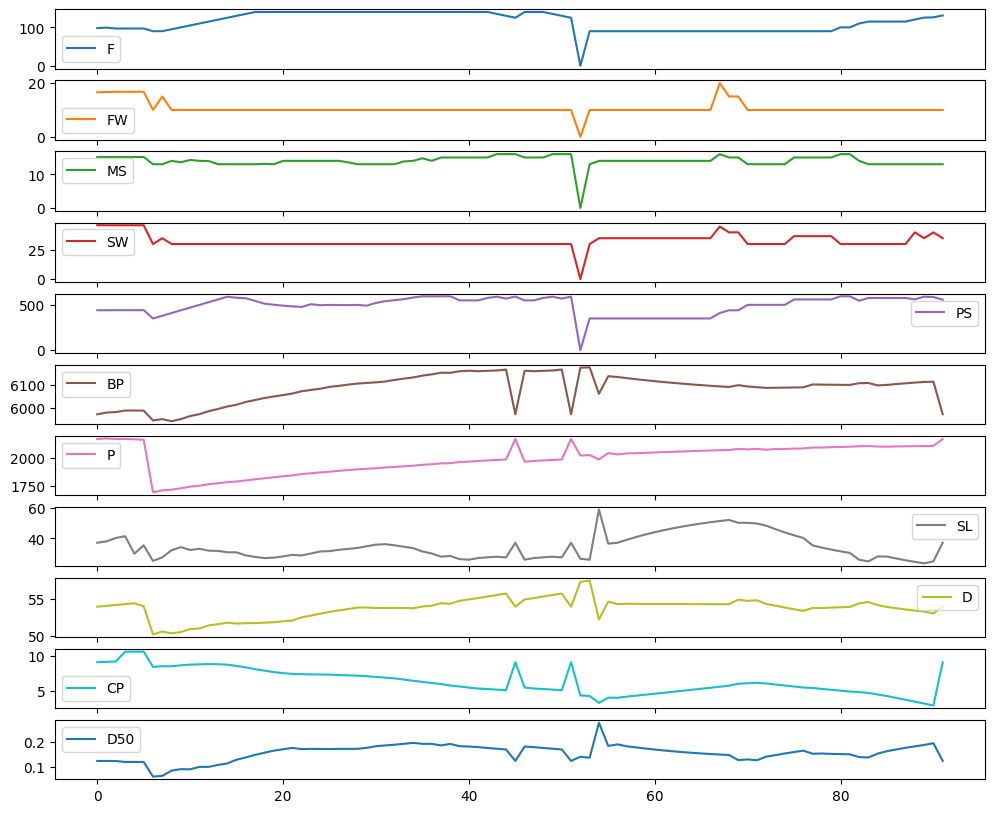

In [13]:
#dfull=dfull.drop('index',axis=1)
dfull.plot(subplots=True,figsize=(12,10))
plt.show()

In [53]:
#RUN ONCE
dbig=dbig[:-1]
dbatch=dbatch[7:-1]
print('ran')

ran


In [23]:
# dbatch[6:].plot(subplots=True)
# plt.show();

In [61]:

dfull=pd.concat((dbig,dbatch),axis=0)
dfull.reset_index(inplace=True)
dfull.drop('index',axis=1,inplace=True)
len(dfull)

121

In [33]:
# dfull.plot(kind='line',subplots=True,figsize=(10,7))
# plt.show;

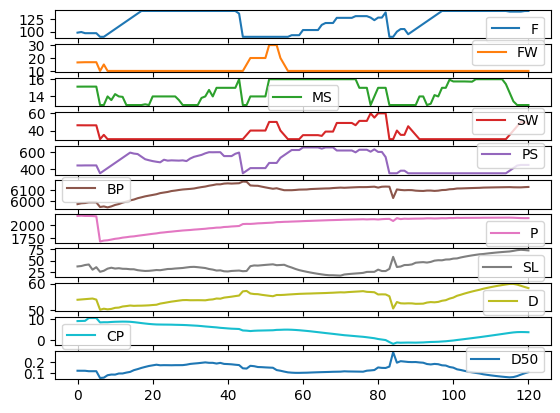

In [62]:
dfull.plot(subplots=True)
plt.show()

In [ ]:
#save data frames for show
mvsim=[]
cvsim=[]
mvsim=d[:-1]
cvsim=d1[:-1]
mvsim.to_excel('mvsim.xlsx',header=True,index=True)
cvsim.to_excel('cvsim.xlsx',header=True,index=True)

In [ ]:
# # set sp's for each CV var.  Play with one at a time   
# BPsp [5:] = 6250        #   15-20 min settling time
# Psp  [5:] = 2200
# SLsp [5:] = 60
# Dsp  [5:] = 55
# CPsp [5:] = 11
# D50sp[10:] = 0.110
# # Adjust setpoints
# dbd={'BP':100,'P':100,'SL':20,'D':5,'CP':3,'D50':0.02} #dead ban dict #changed Sl from 10-20  

In [38]:
dfull.to_excel('dfull.xlsx',header=True,index=True)
#take sp arrays, plot with full data

In [64]:
dbig=[]
dbig=dfull.copy()
#to run again
print('run')

run


# FULL Continuous control v_2


In [15]:

####NOTES FOR MOHAMMED ##
# You’ll want to set up the controller to auto-restart if the computer restarts, it loses communication, or the application crashes. 
#I recommend using the Windows Scheduler to check on the status of the application and attempt to restart it in WARM mode. It can check every minute or at whatever time you desire. On Linux, use cron to schedule tasks.
#for error/exceptions is this doable? can you tell it to restart

# If you are implementing online on a physical system, 
# you may want some logic in the program that directs the NEWVAL from the controller to the process only when the operator has turned on the controller. 
# This is often in the part of the code that controls the Modbus or OPC communication. 
# That layer is another protection against implementing unintended control moves after a controller restart.

##

##
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from IPython.display import clear_output
from gekko import GEKKO

# Make an MP4 animation?
make_mp4 = False
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

######################
# Final time
tf = 45    # min   #remember we used 1 min trained data. #45 is best yet
######################
# number of data points (every 1 minute)
n = tf * 1 + 1

#write mv controller outputs. for testing/plotting controller results
dfw2=np.zeros((5,n)) 
for i, tag in enumerate([dfw2[0],dfw2[1],dfw2[2],dfw2[3],dfw2[4]]):  #Setting starting values to read.
    tag[0]=dbig[MV[i]].iloc[-6]
    tag[1]=dbig[MV[i]].iloc[-5]
    tag[2]=dbig[MV[i]].iloc[-4]
    tag[3]=dbig[MV[i]].iloc[-3]
    tag[4]=dbig[MV[i]].iloc[-2]
    tag[5]=dbig[MV[i]].iloc[-1]
    
#THIS will take 5 minutes of process time. could use Reqctrlmode starting here. or just b aware


#write cv calc/expect/sim outputs. (for testing controller)
dfx2=np.zeros((6,n)) ##NUMbet!!

# MV initialize arrays:
#s is for sensor
Fs  = np.zeros(n)
FWs = np.zeros(n)
MSs = np.zeros(n)
SWs = np.zeros(n)
PSs = np.zeros(n)


for i, tag in enumerate([Fs,FWs,MSs,SWs,PSs]):  #Setting MV starting values. 
    tag[0]=dbig[MV[i]].iloc[-6]                    #would read from process.
    tag[1]=dbig[MV[i]].iloc[-5]    #tag[0]*1.0     #2nd time step added as well.
    tag[2]=dbig[MV[i]].iloc[-4]
    tag[3]=dbig[MV[i]].iloc[-3]
    tag[4]=dbig[MV[i]].iloc[-2]
    tag[5]=dbig[MV[i]].iloc[-1]
    tag[6]=dbig[MV[i]].iloc[-1]
    
# CV values measurement arrays
BPm  = dbig['BP'].iloc[0] * np.ones(n)
Pm   = dbig['P'].iloc[0]  * np.ones(n)
SLm  = dbig['SL'].iloc[0] * np.ones(n)
Dm   = dbig['D'].iloc[0]  * np.ones(n)
CPm  = dbig['CP'].iloc[0] * np.ones(n)
D50m = dbig['D50'].iloc[0]* np.ones(n)

for i, tag in enumerate([BPm,Pm,SLm,Dm,CPm,D50m]):  #Setting MV starting values. 
    tag[0]=dbig[CV[i]].iloc[-6]                    #would read from process.
    tag[1]=dbig[CV[i]].iloc[-5]    #tag[0]*1.0     #2nd time step added as well.
    tag[2]=dbig[CV[i]].iloc[-4]
    tag[3]=dbig[CV[i]].iloc[-3]
    tag[4]=dbig[CV[i]].iloc[-2]
    tag[5]=dbig[CV[i]].iloc[-1]

    
# CV setpointsarrays
BPsp = BPm*1.0
Psp  = Pm*1.0
SLsp = SLm*1.0
Dsp  = Dm*1.0
CPsp = CPm*1.0
D50sp= D50m*1.0

# BPsp = BPm[0] * np.ones(n)
# Psp  = Pm[0]  * np.ones(n)
# SLsp = SLm[0] * np.ones(n)
# Dsp  = Dm[0]  * np.ones(n)
# CPsp = CPm[0] * np.ones(n)
# D50sp= D50m[0]* np.ones(n)

# set sp's for each CV var.  IDEAL
BPsp [5:] = 6250        #   15-20 min settling time
Psp  [5:] = 2200
SLsp [5:] = 75
Dsp  [5:] = 55
CPsp [5:] = 17
D50sp[5:] = 0.110

#Changes 
def change(name,i,sp):
    try:
        BPsp [i:] = 6250        #   15-20 min settling time
        Psp  [i:] = 2200
        SLsp [i:] = 60
        Dsp  [i:] = 55
        CPsp [i:] = 11
        D50sp[i:] = 0.110
        name [i:] = sp
    except:
        print('sp array exceeded, increase tf')

#change(SLsp ,20,30)
change(CPsp,20,11)

#change(D50sp,35,0.110)
#change(CPsp ,50,12)
# change(D50sp,60,0.11)
# change(Psp  ,80,6000)
# change(BPsp ,100,2000)
# change(CPsp ,100,11)
# change(Dsp  ,120,40)

# #Reset
# BPsp [150:] = 6250        #   15-20 min settling time
# Psp  [150:] = 2200
# SLsp [150:] = 60
# Dsp  [150:] = 55
# CPsp [150:] = 11
# D50sp[150:] = 0.110


#dbd={'BP':100,'P':100,'SL':20,'D':5,'CP':3,'D50':0.02} This is defined below. written here for reference only

#########################################################
# Initialize Models    
#########################################################

#Manipulated variables
MV = [ 'F', 'FW', 'MS', 'SW', 'PS']

#Controlled variables
CV = ['BP','P', 'SL', 'D', 'CP', 'D50']

#create control model:

m = GEKKO(remote=False)
y = m.Array(m.CV,6)
u = m.Array(m.MV,5)

y,u = m.arx(p,y,u)

#initial value match to df values. will need to read value from process on real startup
for i in range(len(y)):
    y[i].value=dbig[CV[i]].iloc[-1]  

# rename CVs
BP = y[0]
P  = y[1]
SL = y[2]
D  = y[3]
CP = y[4]
D50= y[5]

# rename MVs
F  = u[0]
FW = u[1]
MS = u[2]
SW = u[3]
PS = u[4]

# # steady state initialization
m.options.IMODE = 1
m.options.SOLVER = 3
#m.solve()

# # initialize to get a feasible solution. does the same thing^^^ basically. but not
#m.options.COLDSTART=2

m.solve()

# # optimize, preserving the initial conditions (TIME_SHIFT=0)
# m.options.TIME_SHIFT=0
# m.options.COLDSTART=0
# m.solve()

# set up MPC
rcm = 3 
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # 3 IPOPT             # change to  1- A for in feas.
m.time=np.linspace(0,tf,n) #set above.
#m.options.COLDSTART = 0   #default
#m.options.TIME_SHIFT= 

###################################
#LOOPS for variables in controller

#deadbands for SPs:
dbd={'BP':100,'P':100,'SL':15,'D':5,'CP':10,'D50':0.02} #  ***. dead ban dict #changed SL from 10-15 ******
                                                        ####### DROPPED CP FROM SOLVER by infinite deadband for CP ######### D50 is close enough.
#Dictionary of variable limits
lim_dict = {
# Controlled variables
'BP': [5500, 6500],
'P': [2000, 2250],
'SL': [40, 80],
'D': [50, 60],
'CP': [8, 14],
'D50': [0.1, 0.2],

# Manipulated variables
'F': [90, 140],
'FW': [10, 30],
'MS': [13, 16],
'PS': [350, 650],
'SW': [30, 60],
}

#Dictionary of desired setpoint values     # dummy
sp_dict = {
'BP': 6250,
'P': 2200,
'SL': 60,
'D': 55,
'CP': 11,
'D50': 0.110,
}


#weights for objective function # Modify setpoint ranges to stay within 10% to 20% of desired setpoint
# wsp_dict = {
#     'BP': 0,
#     'P': 0,
#     'SL': 0,
#     'D': 0,    # 100?
#     'CP': 0,
#     'D50': 0,
# }

#dmax_dict={'F': 10,'FW': 10,'MS': 1,'PS': 60,'SW': 10}   #this is 2 min intervals
dmax_dict={'F': 5,'FW': 5,'MS': 1,'PS': 30,'SW': 5}   #this is for 1 min intervals

dcost_dict={'F': 0.001,'FW': 0.0010,'MS': 0.001,'PS': 0.001,'SW': 0.001} #default 0.00001

#tier_dict={'CS': 0, 'CW': 0,'P': 50,  'L': 50, 'SL': 0,'CP': 0,'D': 100,'RW': 0,'G': 20}   #rank priority

#Set status and limits for manipulated variables
for i,mv_i in enumerate(u):
    tag = MV[i]
    mv_i.STATUS = 1  #manipulated
    mv_i.FSTATUS = 0 #not meas
    mv_i.LOWER = lim_dict[tag][0]
    mv_i.UPPER = lim_dict[tag][1]
    mv_i.DMAX = dmax_dict[tag]
    mv_i.DCOST = dcost_dict[tag]

#MS.FSTATUS=1 disturb
#Set status, setpoint range for controlled variables
for i,cv_i in enumerate(y):
    tag = CV[i]
#     if (cv_i == 'BP')   # can leave out set points
#         cv_i.SPLO = None
#         cv_i.SPHI = None
#         cv_i.STATUS = 0
#     else:
    cv_i.STATUS = 1
    cv_i.FSTATUS = 1
#     cv_i.UPPER = lim_dict[tag][1]   Good idea but infeasible solution caused
#     cv_i.LOWER = lim_dict[tag][0]
    #cv_dict[cv_i][i].TIER = tier_dict[cv_i]  #      #wsp hi and lo?
    cv_i.TAU = 3      # time steps to reach 63% of way to set point
    cv_i.TR_INIT = 2  #recenter to init cond each cycle. default 0 set 2? 
    cv_i.TR_OPEN = 3  #ratio of initial to final gap sphi/lo. can change to 0 for ref traj, 1 is default. 2 iw ratio of open to final db

# run_steps = 60 #600    #delete
# yp = []   #prediction... could i use?

##################################################################
# Create plot
#plt.figure(figsize=(10,7));  only needed if plotting in loop
#plt.ion()   #for live update
#plt.show();

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(5,n-1):
        m.REQCTRLMODE= rcm   #NEED TO READ value each cycle, operator selects ON=3 (Cntrl) or default OFF=2 (Predict)
                            
                            #ALSO need to read Set point changes;
        # Sleep time
        sleep_max = 2.0  # 2 seconds orginially;  # tf/(n-1) in m.time ? this for waiting: chnage to 1 min
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time


        # Read CV measurements Here
        if i>=6:
            BPm[i] =smbp  #prev solved sim value. float
            Pm[i]  =smp 
            SLm[i] =smsl
            Dm[i]  =smd 
            CPm[i] =smcp
            D50m[i]=smd50


        # Insert measurements
        BP.MEAS  = BPm[i]
        P.MEAS   =  Pm[i]
        SL.MEAS  = SLm[i]
        D.MEAS   =  Dm[i]
        CP.MEAS  = CPm[i]
        D50.MEAS =D50m[i]
        #MS.MEAS  = 14 + 1.5* np.sin(i*np.pi/7)


        # Adjust setpoints
        BP.SPHI = BPsp[i] + dbd['BP']
        BP.SPLO = BPsp[i] - dbd['BP']
        P.SPHI = Psp[i] + dbd['P']
        P.SPLO = Psp[i] - dbd['P']
        SL.SPHI = SLsp[i] + dbd['SL']
        SL.SPLO = SLsp[i] - dbd['SL']
        D.SPHI = Dsp[i] + dbd['D']
        D.SPLO = Dsp[i] - dbd['D']
        CP.SPHI = CPsp[i] + dbd['CP']
        CP.SPLO = CPsp[i] - dbd['CP']
        D50.SPHI = D50sp[i] + dbd['D50']
        D50.SPLO = D50sp[i] - dbd['D50']

        # Adjust MV's with MPC 
        if i==7:
            m.options.MAX_TIME= 15.0 # after first (2nd) solution
        #m.solve()
        try:
            m.solve()
            m.options.TIME_SHIFT=1
        except:
            m.options.TIME_SHIFT=2

    #     if m.options.APPSTATUS == 1:
    #         #save extra soln info optn
    #         good=True
    #     else:
    #         print('fail soln')

        #Setting MVs starting at the next step in time
        Fs[i+1]   =  F.value[0]        
        FWs[i+1]  = FW.value[0]
        MSs[i+1]  = MS.value[0]         
        SWs[i+1]  = SW.value[0]
        PSs[i+1]  = PS.value[0]

        #solve for CV response:

    #######################################################################

            # SIMULATOR
            #             IMODE 4 

        sm = GEKKO(remote=False)

        # Init GEKKO ARX Sim

        sy = sm.Array(sm.CV,6)
        su = sm.Array(sm.MV,5)

        #set starting value from process reading. (always the same)
        for k in range(len(sy)):
            sy[k].value=dbig[CV[k]].iloc[0]

        sy,su = sm.arx(p,sy,su)    #p array matches

        # MV inputs
        tf = i # final time     ##########                #Hey, could simulate only a 60 point window to save computation
        u1 = np.zeros(tf+1 +len(dbig) )   #add
        u2 = u1.copy()
        u3 = u2.copy()
        u4 = u3.copy()
        u5 = u4.copy()

        ld=len(dbig)
        u1[0:ld] = dbig['F'].iloc[0:ld]     #read the array sensor history of MV to present
        u2[0:ld] = dbig['FW'].iloc[0:ld]
        u3[0:ld] = dbig['MS'].iloc[0:ld]
        u4[0:ld] = dbig['SW'].iloc[0:ld]
        u5[0:ld] = dbig['PS'].iloc[0:ld]

        u1[ld:] = Fs[0:tf+1]     #read the array sensor history of MV to present
        u2[ld:] = FWs[0:tf+1]
        u3[ld:] = MSs[0:tf+1]
        u4[ld:] = SWs[0:tf+1]
        u5[ld:] = PSs[0:tf+1]

        su[0].value = u1
        su[1].value = u2
        su[2].value = u3
        su[3].value = u4
        su[4].value = u5

        # customize names        ## drop
        mv1 = su[0]; mv2 = su[1]; mv3 = su[2]; mv4 = su[3]; mv5 = su[4]
        cv1 = sy[0]; cv2 = sy[1]; cv3 = sy[2]; cv4 = sy[3]; cv5 = sy[4]; cv6 = sy[5]

        # options
        sm.time = np.linspace(0,tf +ld,tf+1 +ld)
        sm.options.IMODE = 4; sm.options.nodes = 2

        # simulate
        sm.solve(disp=False)

        #write CV simulated values to array:
        smbp= cv1.value[-1]
        #print('CV sim value for bp',smbp) #check
        smp = cv2.value[-1]
        smsl= cv3.value[-1]
        smd = cv4.value[-1]
        smcp= cv5.value[-1]
        smd50=cv6.value[-1]

    ##################################

        # get additional solution information ( for plotting, etc)
        with open(m.path+'//results.json') as f:
            results = json.load(f)
    #       #else Solution failed
    #        MV1[i+1]  = prev val
    #        MV2[i+1]  = prev val
except KeyboardInterrupt:
    print(f'Shutting Down. time={i} minutes')
#     # Write to a new array/file when testing. would write to OPC
#     dfw[0,i] =  F.value[1]
#     #print('dfw',dfw[0]) #check if writing
#     dfw[1,i] = FW.value[1]
#     dfw[2,i] = MS.value[1]
#     dfw[3,i] = SW.value[1]
#     dfw[4,i] = PS.value[1]


dfw2[0] =  Fs
dfw2[1] = FWs
dfw2[2] = MSs
dfw2[3] = SWs
dfw2[4] = PSs
    
#For plotting, compile:
dfx2[0] = BPm
dfx2[1] = Pm
dfx2[2] = SLm
dfx2[3] = Dm
dfx2[4] = CPm
dfx2[5] = D50m

    #Plotting. Had trouble live plotting
    #computational time? other bugs 

#plot MV moves
d2=pd.DataFrame(dfw2.T)
d2.columns= ['F','FW','MS','SW','PS']
# d[:-1].plot(kind='line',subplots=True, figsize=(10,7))
# plt.show();

#plot CV simulation 
plt.figure()
d12=pd.DataFrame(dfx2.T)
d12.columns= ['BP','P','SL','D','CP','D50']
# d1[:-1].plot(kind='line',subplots=True, figsize=(10,7))
# plt.show();


dbatch=pd.concat([d2,d12],axis=1);
dbatch[:-1].plot(kind='line',subplots=True, figsize=(14,9));
plt.show();


NameError: name 'dbig' is not defined

#### D50 SP 0.11 to time 20 
#D50 SP 0.13 to time 45
#D50 SP 0.11 to time 60
#D50 SP 0.13 to time 85
#CP SP 8 D50 0.11 to time 100



# BPsp_ =np.append(BPsp [5:],BPsp [5:])
# Psp_  =np.append(Psp  [5:],Psp  [5:])
# SLsp_ =np.append(SLsp [5:],SLsp [5:])
# Dsp_  =np.append(Dsp  [5:],Dsp  [5:])
# CPsp_ =np.append(CPsp [5:],CPsp [5:])
# D50sp_=np.append(D50sp[5:],D50sp[5:])
# BPsp_ =np.append(np.zeros(5),BPsp_ )
# Psp_  =np.append(np.zeros(5),Psp_  )
# SLsp_ =np.append(np.zeros(5),SLsp_ )
# Dsp_  =np.append(np.zeros(5),Dsp_  )
# CPsp_ =np.append(np.zeros(5),CPsp_ )
# D50sp_=np.append(np.zeros(5),D50sp_)
print('done')


In [70]:
len(CPsp)

46

In [100]:
BPsp_11 =np.append(BPsp_1 ,BPsp[5:])
Psp_11  =np.append(Psp_1  ,Psp [5:])
SLsp_11 =np.append(SLsp_1 ,SLsp[5:])
Dsp_11  =np.append(Dsp_1  ,Dsp [5:])
CPsp_11 =np.append(CPsp_1 ,CPsp[5:])
D50sp_11=np.append(D50sp_1,D50sp[5:])

In [101]:
dfull=pd.concat((dbig[:-1],dbatch[6:-1]))

In [106]:
dfsp

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.00
2,0.0,0.0,0.0,0.0,0.0,0.00
3,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...
164,6250.0,2200.0,60.0,55.0,11.0,0.11
165,6250.0,2200.0,60.0,55.0,11.0,0.11
166,6250.0,2200.0,60.0,55.0,11.0,0.11
167,6250.0,2200.0,60.0,55.0,11.0,0.11


In [ ]:
#to excel!
dfsp=pd.DataFrame(np.array([BPsp_11.T ,Psp_11.T  ,SLsp_11.T ,Dsp_11.T  ,CPsp_11.T ,D50sp_11.T ]).T)
#dfsp=dfsp.drop(4)
#dfsp=dfsp.reset_index()
dftot=pd.concat((dfull,dfsp),axis=1)
dftot.to_excel('plot_data2.xlsx',header=True,index=True)

In [3]:
import time

In [8]:
q=0
try:
    while q!=1:
        for i in range(10):
            j=i**i
            time.sleep(1)
            print(j)
            if i==2:
                i=0
        
except KeyboardInterrupt:
    # Turn off heaters and close connection

    print('Shutting down')


print('hello')

Shutting down
hello


In [ ]:
#make the arrays start at0
#use first 5 (real data)
#run initial solve

q=0
try:
    while q!=1:
        for i in range(5):
            j=i**i
            time.sleep(1)
            print(j)
            #store data points so they dont overlap in array
        #before running for loop again:
        #reinitialize arrays using last 5 data points in arrays
        

except KeyboardInterrupt:
    # Turn off heaters and close connection

    print('Shutting down')


print('plot all data')

meeting:
    - dont feel like they listened with real intent yesterday
    wasn't the best presentation but come on
    - the step test would improve results from looks decent to totally viable ($$$)
        - 3x as good
    - can put online as is 
    if step test later- reach out. with 30 more hours/2 weeks i can have new data into a new controller that's certainly better-- and i will have a little time 
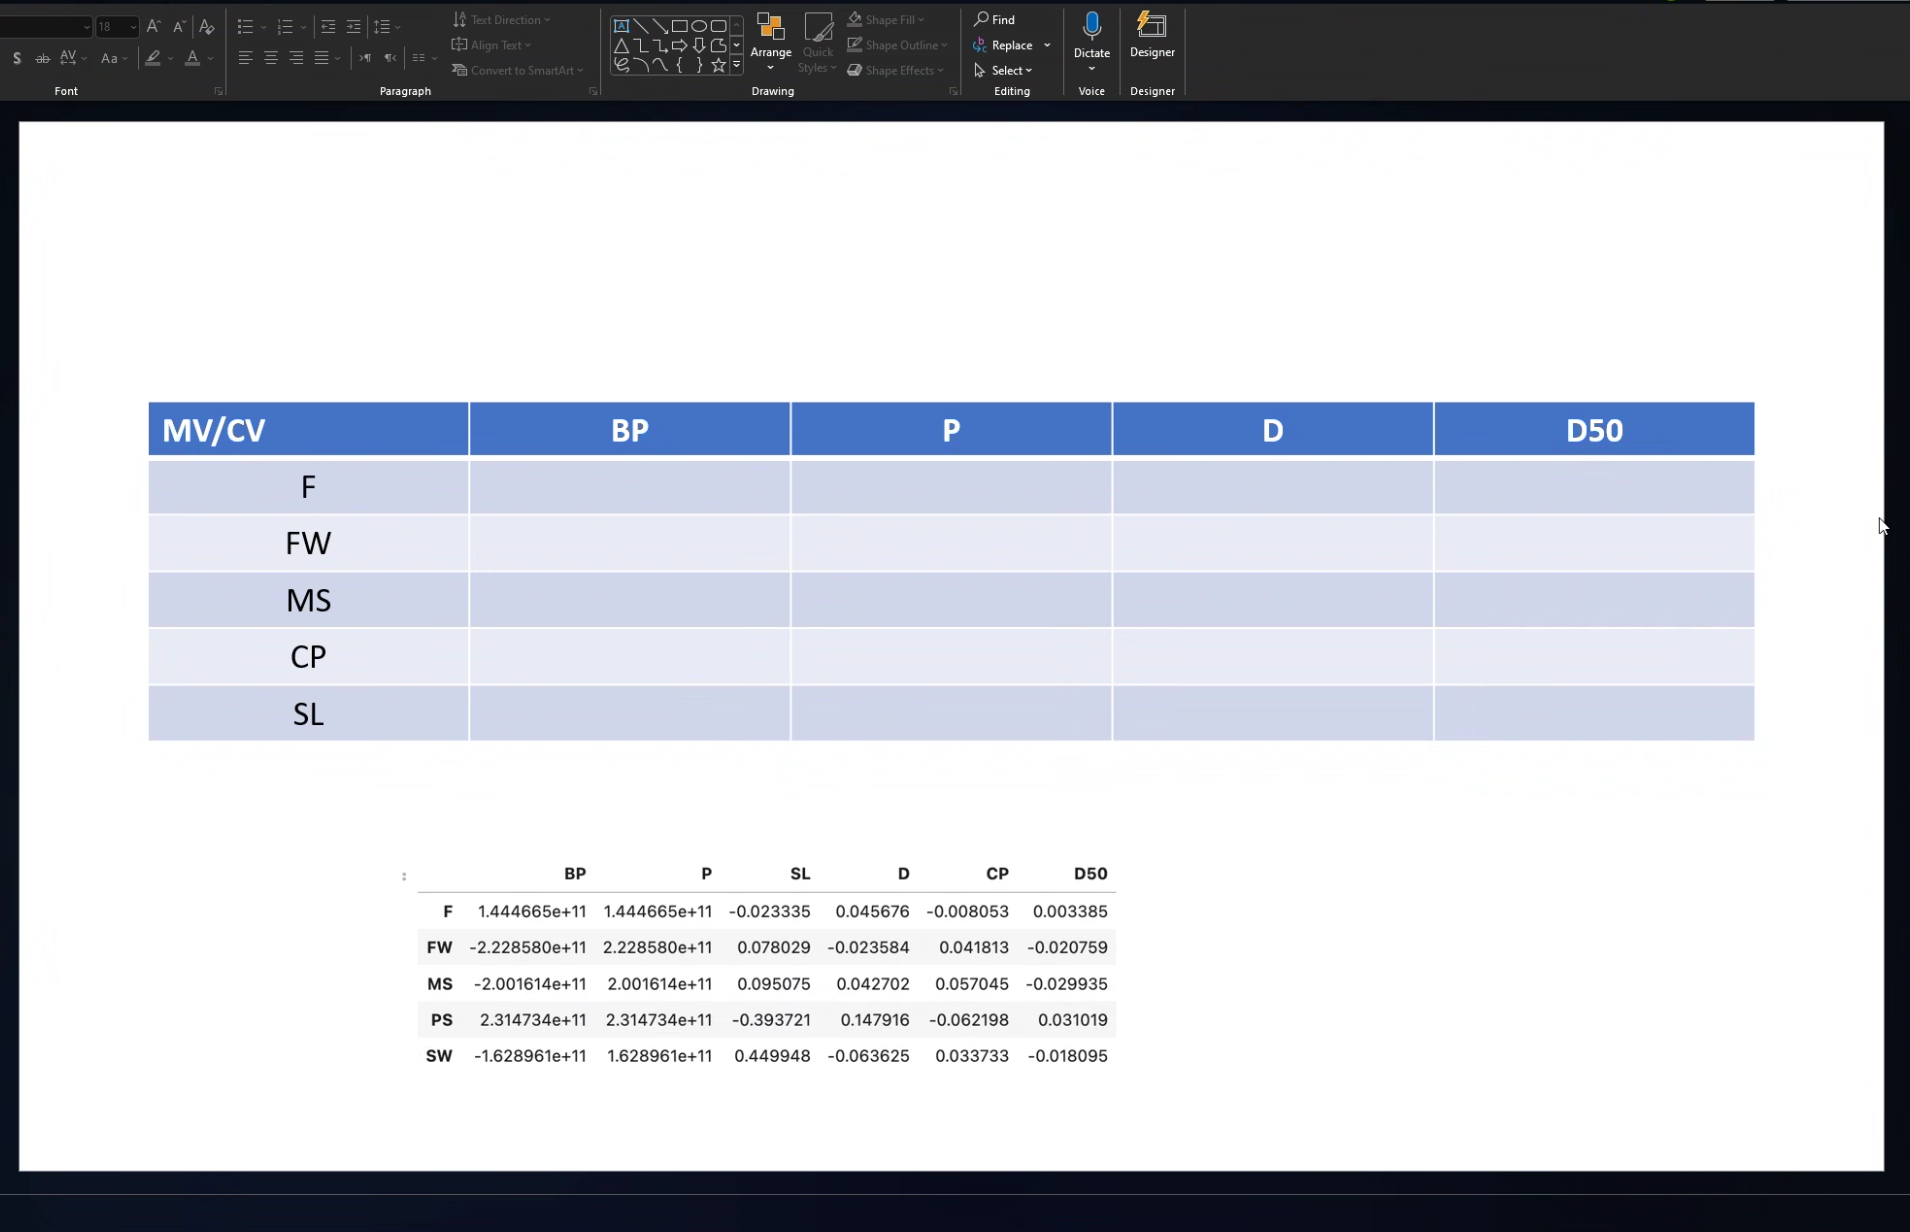

In [9]:
N=0
while N==2:
    time.sleep(2)
    N=int(input('Write integer'))
    print('run program')

Write integer 1


run program


In [14]:
Flag = True
while Flag:
    try:
        print('scan bar code')
        user_inp = input()
        if user_inp != '':
            Flag = False
    except:
        Print('except part') 

scan bar code


scan bar code


scan bar code


scan bar code


scan bar code


NameError: name 'Print' is not defined